# Conversion of units

```
  1 bohr           =  0.529177249      angstrom
  1 hartree        =  27.2113961       eV
                   =  219474.63068     cm^-1
                   =  627.50956        kcal/mol
  1 electron mass  =  5.4857990e-4     u ( unified atomic mass unit)
                   =  9.1093897e-31    kg
  1 cal            =  4.184            J  (by definition)
  N_avogadro       =  6.0221367e23     (per mol)
  1 Debye          =  0.393456         a.u.
```

Atomic masses (including electrons) of most abundant isotope in a.m.u.
```
  H     1.007825
  D     2.0140
  He    4.0026
  C    12
  N    14.00307
  O    15.99491
  F    18.9984
  S    31.97207
  Cl   34.96885
```

# Input example:

Notes:
- Variable names must be the ones given below and separated from values by a semicolon, ":"
- If multiple inputs, provide a comma-separated list
- Units of dist == Angs
- Atom/frame indeces must be in Python format (i.e. starting at zero <=> i-1 if i starts at 1)
- By default the concentric shells are calculated along the main diagonal


```
positions:  /Users/enriquej/Desktop/CALC/Python/analyze_dynamics/md_ch3_ch2oh-pos-1.xyz
velocities: /Users/enriquej/Desktop/CALC/Python/analyze_dynamics/md_ch3_ch2oh-VEL-1.xyz
ener:       /Users/enriquej/Desktop/CALC/Python/analyze_dynamics/md_ch3_ch2oh-1.ener
output_dir: /Users/enriquej/Desktop/CALC/Python/analyze_dynamics/test
cell_params: 26.318, 28.330, 50.0 # a, b, c (Angs)
center:     1732 # atom to centner on (i-1) or x y z point (angs)
1st_frame:  0    # 
Last_frame: -1   # 
1st_sph:    6    # Radius 1st sphere (Angs)
nr_shells: 5     # number of shells (Angs)
time_step:  1.0  # in fs
reagents:   1728,1729,1730,1731,1732,1733,1734,1735,1736  # atomic indeces of atoms
selection:  all  # surface's atoms to study (all/list of indeces)
```

# The program

Here you run the program.
The input is read, parameters are stored, data is read from XYZs/ener files and ASE is run.

Returns:

- `KE_per_shell`: total kinetic energy of all H2Os molecules in each shell (list of np arrays)
- `KE_per_shell_mass_wgt`: mass-weighted KE of H2Os molecs per shell (list of np arrays)
- `KE_per_shell_nr_wgtd`: nr-of-water molcs weighted KE of H2Os per shell (list of np arrays)
- `KE_react`: KE of reactants
- `KE_react_mass_wgtd`: mass-weighted KE of reactants
- `KE_selected`: KE of selected molecules
- `KE_selected_mass_wgtd`: mass-weighted KE of selected molecules

This data is also stored into CSVs.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import time, os, sys, importlib, matplotlib
from ase.io import read, write
from ase.visualize import view
## Functions to read/write info
#importlib.reload(sys.modules['IO_fns'])
sys.path.insert(1, 'CODE_md_analyzer') # I have the functions are stored in a different folder
from IO_fns import INPUT_READER, FAST_POS_VEL_READER, ENER_READER, SAVE_KE_Shells, SAVE_KE_Reactants, SAVE_KE_Selection, SAVE_KE_file
## Functions to run calcs
#importlib.reload(sys.modules['CALC_fns'])
from CALC_fns import WatInside, add_cell, INST_TEMP, MOVING_AVERAGE, PLOT_ENERGY_AVERAGES

In [2]:
%%time
print("Reading input file...")
######################################
# LOAD INPUT FILE DATA
######################################
IDATA = INPUT_READER(path="INPUT_CH3CH3.txt") #    INPUT_CH3CHO  INPUT_CH3CH3
#print(IDATA.keys())

######################################
# Reading MD data
######################################
inFile_pos = IDATA['positions']
inFile_vel = IDATA['velocities']
inFile_ene = IDATA['ener']
# Reading in all frames, with positions and velocities per each frame
print(" > Reading MD positions & velocities")
myMD = FAST_POS_VEL_READER(inFile_pos,inFile_vel) ##### ------------- Automatically creating ATOMS objects here
# Read in .ener data for each frame
Time, Kin, Temp, Pot = ENER_READER(inFile_ene)
##### SANITY CHECK #####
## Same lengths .ener and pos/vel?
print("    Running sanity checks:")
print("     1. Are lengths .ener == vel/pos?", len(Temp)==len(myMD))
print("     2. Compare kin energies from .ener and from vels...")
# Is the .ener KE == to the one from the velocities?
for i in range(10):
    ke = myMD[-i].get_kinetic_energy()/5.4857990e-4
    print("       > {:.9f} vs {:.9f} = {:.2e}".format(ke,Kin[-i],ke-Kin[-i]))
print('       >> If these numbers are not very similar, you should get upset!')
#print("\n  ==================================")

######################################
# Reading parameters
######################################
print("  > Reading parameters")
OUT_DIR   = IDATA["output_dir"]
REAGENTS  = IDATA["reagents"]
SELECTION = IDATA["selection"]
tstep     = IDATA['time_step']
cell      = IDATA["cell_params"]
fr0, frF  = IDATA["1st_frame"], IDATA["Last_frame"]
in_sph_rad= IDATA["1st_sph"]
nr_shells = IDATA['nr_shells']
show_shells= IDATA['show_shells']
# Mods/Printing for parameters above
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
if SELECTION in ['all','All','ALL','*']:
    SELECTION = [int(i) for i in range(len(myMD[0])) if i not in REAGENTS]
if frF==-1: frF = len(myMD)
print("    >> Reagents:",myMD[0][REAGENTS].get_chemical_formula(),"; ids:",REAGENTS)
print("    >> Selection:",myMD[0][SELECTION].get_chemical_formula())
print("    >> tstep:",tstep)
print("    >> Initial/Final frames: {}/{}".format(fr0,frF))
print("    >> Radius 1st sph (Angs): {}".format(in_sph_rad))
print("    >> Number of concentric shells (Angs): {}".format(nr_shells))
print("    >> Show shells?",show_shells)
# Centering all frames at certain position
if isinstance(IDATA["center"],int):
    AT_IND_CNTR = IDATA["center"]
    NEW_CENTER  = np.asarray(myMD[-1].get_positions()[AT_IND_CNTR])-np.asarray(cell)/2 # get new center (C atom, #0 in 1st frame) and center of cell
    print("    >> Atom to center on: {} ([{:.4f},{:.4f},{:.4f}] Angs)".format(AT_IND_CNTR,NEW_CENTER[0],NEW_CENTER[1],NEW_CENTER[2]))
elif isinstance(IDATA["center"],list):
    NEW_CENTER  = IDATA["center"]
    print("    >> New center: [{:.4f},{:.4f},{:.4f}] Angs".format(NEW_CENTER[0],NEW_CENTER[1],NEW_CENTER[2]))
for frame in myMD:
    if not frame.get_cell().any(): # if all get_cell params are 0 (cell unset)
        frame=add_cell(frame,cell,NEW_CENTER)
# Make sphere/shells list out of CellDiag
CellDiag   = np.sqrt(cell[0]**2+cell[1]**2+cell[2]**2) # major diagonal of the cell
print("    >> Major cell's diagonal: {:.4f} Angs".format(CellDiag))
SHELL_Rs = sorted(np.linspace(in_sph_rad,int(CellDiag/2),nr_shells), key=float) # radii in Angs
IDATA['SHELL_Rs'] = SHELL_Rs
print("    >> Shell radii:",SHELL_Rs)
# Get cell params (x,y,z) in ASE format
cell = myMD[0].get_cell_lengths_and_angles()[0:3]
# For timing reasons I advice to only make the divisions into zones for the 1st frame
#  this is done by setting the following variable to True
just_1st = True

#########################
##### Extract KEs   #####
#########################
print('RUNNING ANALYSIS')
FRAMES = myMD[fr0:frF] # this makes a copy of the data to work on
#
#-----------------------------------------
# Initialize DATA matrices as numpy arrays
#-----------------------------------------
KE_per_shell           = np.zeros(shape=(len(SHELL_Rs),len(FRAMES))) # KE per shell
KE_per_shell_mass_wgtd = np.copy(KE_per_shell) # KE mass independent
KE_per_shell_nr_wgtd   = np.copy(KE_per_shell) # KE over nr of water molecules
#
KE_react           = np.zeros(shape=(len(FRAMES)))
KE_react_mass_wgtd = np.copy(KE_react)
#
KE_selected           = np.zeros(shape=(len(FRAMES)))
KE_selected_mass_wgtd = np.copy(KE_selected)
#
KE_ice           = np.zeros(shape=(len(FRAMES)))
KE_ice_mass_wgtd = np.copy(KE_ice)
#
#---------------
# MAIN LOOP 
#---------------
# For each frame, get the idxs of atoms inside (except those from the reagents)
for fr_idx,fr in enumerate(FRAMES[:]):
    atoms     = fr.copy()
    del atoms[ REAGENTS ] # remove the REAGENTS
    # kin. Energy of reactants:
    KE_react[fr_idx]           = fr[REAGENTS].get_kinetic_energy()/0.0005485799096500715  # (change units mass)
    KE_react_mass_wgtd[fr_idx] = fr[REAGENTS].get_kinetic_energy()/(sum(fr[REAGENTS].get_masses()))
    #
    KE_selected[fr_idx]           = fr[SELECTION].get_kinetic_energy()/0.0005485799096500715  
    KE_selected_mass_wgtd[fr_idx] = fr[SELECTION].get_kinetic_energy()/(sum(fr[SELECTION].get_masses()))
    #
    KE_ice[fr_idx]           = atoms.get_kinetic_energy()/0.0005485799096500715  
    KE_ice_mass_wgtd[fr_idx] = atoms.get_kinetic_energy()/0.0005485799096500715  
    #
    #--------------------#
    #:::::: DATA! :::::::#
    # Each data pack contains three
    # lists: atoms, oxygens and 
    # reconstructed water molecules
    # all inside the defined shells.
    #--------------------#
    if [just_1st,fr_idx] == [True,0] or just_1st == False:
        ATOMS, OX, WATERS = WatInside(atoms,SHELL_Rs,cell)
    for i,wat_in_shell in enumerate(WATERS):
        KE_per_shell[i,fr_idx]           = atoms[wat_in_shell].get_kinetic_energy()/0.0005485799096500715
        KE_per_shell_mass_wgtd[i,fr_idx] = atoms[wat_in_shell].get_kinetic_energy()/(sum(atoms[wat_in_shell].get_masses()))
        KE_per_shell_nr_wgtd[i,fr_idx]   = atoms[wat_in_shell].get_kinetic_energy()/(len(atoms[wat_in_shell])/3)/0.0005485799096500715
        if fr_idx == range(len(FRAMES))[0]:
            write(OUT_DIR+"/shell_{}.xyz".format(int(i)),atoms[wat_in_shell])
            if show_shells: view(atoms[wat_in_shell])

#---------------
# File saving
#---------------
names    = ['KE_over_mass_per_shell',  'KE_per_shell', 'KE_per_nr_waters_per_shell']
list_data = [KE_per_shell_mass_wgtd, KE_per_shell, KE_per_shell_nr_wgtd]
# Store KE of each sph for all frames
SAVE_KE_Shells(list_data,names,outdir=OUT_DIR,params=IDATA)
# Store kE Reactants
SAVE_KE_Reactants(KE_react,outdir=OUT_DIR,params=IDATA)
# Store kE slected waters
SAVE_KE_Selection(KE_selected,outdir=OUT_DIR,params=IDATA)
# Store KE ice
SAVE_KE_file("ice_KE.csv",KE_ice,outdir=OUT_DIR,params=IDATA)

print("-- Done")

Reading input file...
 > Reading MD positions & velocities
    Running sanity checks:
     1. Are lengths .ener == vel/pos? True
     2. Compare kin energies from .ener and from vels...
       > 0.248016380 vs 0.248010223 = 6.16e-06
       > 0.373688858 vs 0.373677020 = 1.18e-05
       > 0.364004511 vs 0.363993299 = 1.12e-05
       > 0.357429709 vs 0.357418940 = 1.08e-05
       > 0.358346350 vs 0.358335571 = 1.08e-05
       > 0.359367837 vs 0.359356982 = 1.09e-05
       > 0.360263896 vs 0.360252926 = 1.10e-05
       > 0.361863266 vs 0.361852121 = 1.11e-05
       > 0.361119681 vs 0.361108521 = 1.12e-05
       > 0.358445874 vs 0.358434856 = 1.10e-05
       >> If these numbers are not very similar, you should get upset!
  > Reading parameters
    >> Reagents: C2H6 ; ids: [1735, 1733, 1734, 1732, 1729, 1730, 1731, 1728]
    >> Selection: H1152O576
    >> tstep: 1.0
    >> Initial/Final frames: 0/6473
    >> Radius 1st sph (Angs): 6.0
    >> Number of concentric shells (Angs): 5
    >> Show

/Users/enriquej/miniconda3/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.cellpar() instead
  warnings.warn(warning)


-- Done
CPU times: user 1min 14s, sys: 14.2 s, total: 1min 28s
Wall time: 52.5 s


In [3]:
#view(myMD)

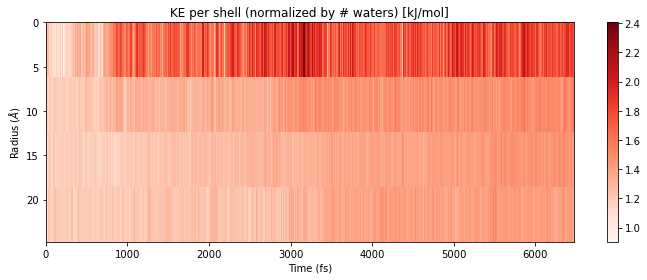

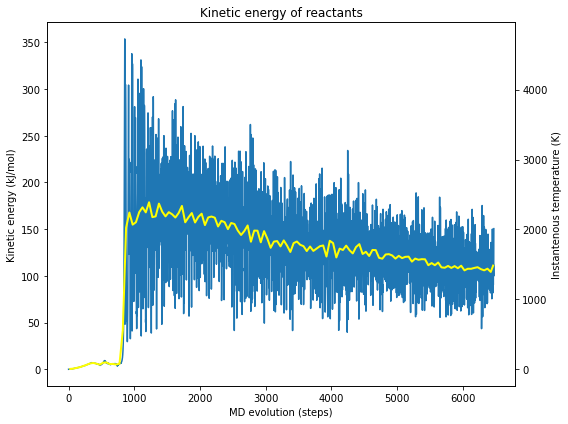

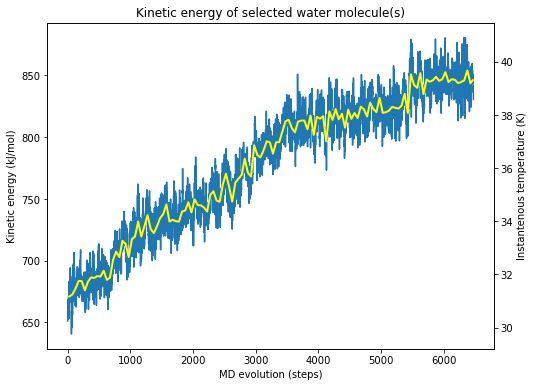

In [4]:
#---------------
# 2D plot
#---------------
for myDATA in [KE_per_shell_nr_wgtd[:-1]*2625.5]: # plot all shells excpet last one (too noisy)
    extent  = [fr0*tstep,frF*tstep,0.0,max(SHELL_Rs[:-1])]  
    fig, ax = plt.subplots(figsize=(10,4))
    im   = ax.imshow(myDATA,cmap=plt.cm.Reds,interpolation='nearest',aspect='auto',origin='lower',extent=extent)#,vmin=min([min(i) for i in myDATA]),vmax=max(KE_per_shell_mass_wgtd[0]))
    ax.invert_yaxis()
    cbar = fig.colorbar(im, orientation='vertical')
    ax.set_xlabel('Time (fs)')
    ax.set_ylabel(r'Radius ($\AA$)')
    ax.set_title("KE per shell (normalized by # waters) [kJ/mol]")
    plt.tight_layout()
    plt.savefig(OUT_DIR+"/2D.png",dpi=300)
    plt.show()   

#---------------
# KE reactants
#---------------
fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(8,6)) 
ax.plot(range(len(KE_react)),KE_react*2625.5)
#
# Add 2ary axis
ax2=ax.twinx()
#temperatures = [i[REAGENTS].get_temperature() for i in FRAMES]
temperatures = INST_TEMP(FRAMES,selection=REAGENTS)
ax2.plot(range(len(temperatures)),temperatures,c="white",alpha=0.0)
ax2.set_ylabel("Instantenous temperature (K)")
#
# Moving averages
x,y = MOVING_AVERAGE(KE_react*2625.5)
ax.plot(x,y,c='yellow',lw=2)
#
ax.set_title(r'Kinetic energy of reactants')
ax.set_xlabel('MD evolution (steps)')
#ax.set_xlabel('Time ()')
ax.set_ylabel('Kinetic energy (kJ/mol)')
plt.tight_layout()
plt.savefig(OUT_DIR+"/kinE_reactants.png", dpi=300)
plt.show()

#---------------
# KE selected
#---------------
fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(8,6)) 
ax.plot(range(len(KE_selected)),KE_selected*2625.5)
#
# Add 2ary axis
ax2=ax.twinx()
#temperatures = [i[SELECTION].get_temperature() for i in FRAMES]
temperatures = INST_TEMP(FRAMES,selection=SELECTION)
ax2.plot(range(len(temperatures)),temperatures,c="white",alpha=0.0)
ax2.set_ylabel("Instantenous temperature (K)")
#
# Moving averages
x,y = MOVING_AVERAGE(KE_selected*2625.5)
ax.plot(x,y,c='yellow',lw=2)
#
ax.set_title(r'Kinetic energy of selected water molecule(s)')
ax.set_xlabel('MD evolution (steps)')
#ax.set_xlabel('Time ()')
ax.set_ylabel('Kinetic energy (kJ/mol)')
plt.savefig(OUT_DIR+"/kinE_selected.png", dpi=300)
plt.show()

### Plotting spherical energy dispersion for different spherical radius

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


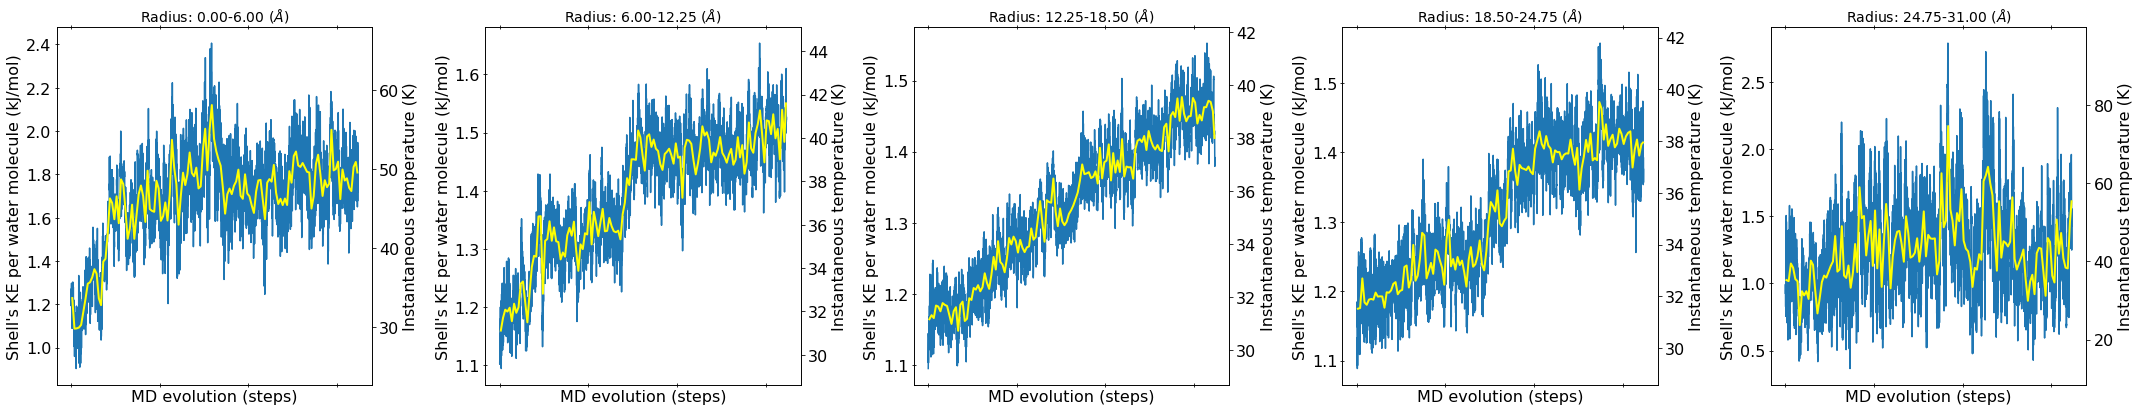

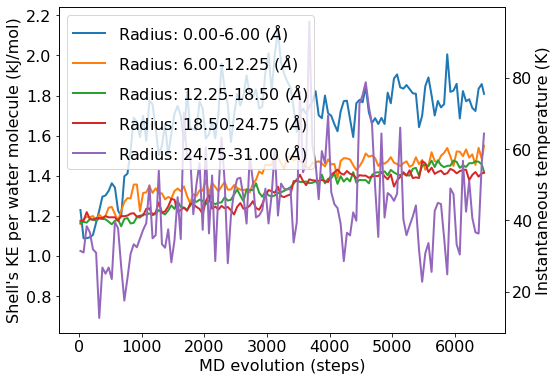

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
fig, axs= plt.subplots(nrows=1, ncols=len(SHELL_Rs),figsize=(6*len(SHELL_Rs),6)) 

fig_all, axs_all =plt.subplots(nrows=1, ncols=1,figsize=(8,6)) 
#
for ax,sph,k,indeces in zip(axs,SHELL_Rs,range(len(SHELL_Rs)),WATERS):
    ax.plot(range(len(KE_per_shell_nr_wgtd[k][:])) , KE_per_shell_nr_wgtd[k][:]*2625.5)
    #
    # Moving averages
    x,y = MOVING_AVERAGE(KE_per_shell_nr_wgtd[k][:]*2625.5)
    ax.plot(x,y,c='yellow',lw=2)
    
    #
    # Add 2ary axis for instantaneous Temperature
    ax2=ax.twinx()
    temperatures = INST_TEMP(FRAMES,selection=indeces)
    ax2.plot(range(len(temperatures)),temperatures,c="white",alpha=0.0)
    ax2.set_ylabel("Instantaneous temperature (K)")
    #
    if k==0:
        previous_radius = 0
    else:
        previous_radius = SHELL_Rs[k-1]
    label = r'Radius: {:.2f}-{:.2f} ($\AA$)'.format(previous_radius,sph)
    #ax.text(0.7,0.1,label, ha='center',va='center', transform=ax.transAxes,fontsize=14)
    ax.set_title(label,fontsize=14)
    ax.tick_params(axis='both', direction='inout', which='major',bottom=True,top=True,left=True,right=False)
    ## Remove if unneded:
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    axs_all.plot(x,y,lw=2,label=label)#r"r$_{shell}$ = "+str(sph))
for ax in axs[:]:
    ax.tick_params(labelbottom=False)
for ax in axs[:]:#[axs[0],axs[3]]:
    # Remove if neded:
    #ax.set_ylabel("Shell's KE ($a_0^2/s^2$)")
    ax.set_ylabel("Shell's KE per water molecule (kJ/mol)")
for ax in axs[:]:
    # Remove if neded:
    ax.set_xlabel('MD evolution (steps)')
    #ax.set_xlabel('MD evolution log(steps)')

axs_all.set_xlabel('MD evolution (steps)')
axs_all.set_ylabel("Shell's KE per water molecule (kJ/mol)")
axs_all2=axs_all.twinx()
axs_all2.plot(range(len(temperatures)),temperatures,c="white",alpha=0.0)
axs_all2.set_ylabel("Instantaneous temperature (K)")
axs_all.legend()

fig.tight_layout()
fig.savefig(OUT_DIR+"/spherical_shells.png", dpi=400)
fig_all.savefig(OUT_DIR+"/all_spherical_shells.png", dpi=300)
plt.show()

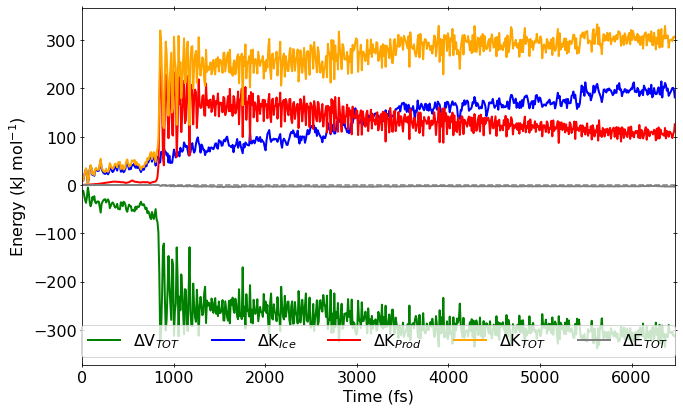

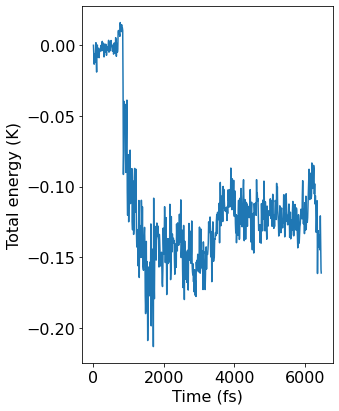

In [6]:
x, Pot_avgd    = MOVING_AVERAGE(Pot,10) # read from .ener
x, IceKin_avgd = MOVING_AVERAGE(KE_ice,10) # obtained with ase
x, RgKin_avgd  = MOVING_AVERAGE(KE_react,10)  # obtained with ase
x, TotKin_avgd = MOVING_AVERAGE(Kin,10)  # read from .ener
x, TotEn_avgd  = MOVING_AVERAGE(np.array(Kin)+np.array(Pot),10)  # read from .ener
other = [[(np.array(TotKin_avgd)-Kin[0])*2625.5,r"$\Delta$K$_{TOT}$",'orange'],[(np.array(TotEn_avgd)-TotEn_avgd[0])*2625.5,r"$\Delta$E$_{TOT}$",'grey']]
time_Evol = np.array(x)*tstep

ax = PLOT_ENERGY_AVERAGES(time_Evol,(np.array(Pot_avgd)-Pot[0])*2625.5,(np.array(IceKin_avgd)-KE_ice[0])*2625.5,(np.array(RgKin_avgd)-KE_react[0])*2625.5,Other=other)

plt.savefig(OUT_DIR+"/comparison_energetics.png", dpi=200)
plt.show()

# Detail of Etot
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(5,6))
ax.plot(time_Evol,(np.array(TotEn_avgd)-TotEn_avgd[0])*120.273116)
ax.set_xlabel("Time (fs)")
ax.set_ylabel("Total energy (K)")
plt.tight_layout()
plt.savefig(OUT_DIR+"/Etot_in_kJmol.png",dpi=200)
plt.show()

## Phonon VDOS (aka: PDOS, phonon spectrum...)

I calculate it using ```pwtools```'s direct conversion from velocities, which does not go through the traditional velocity autocorrelation function (VACF).

Find more details here:
```
https://elcorto.github.io/pwtools/written/background/phonon_dos.html
https://elcorto.github.io/pwtools/generated/api/pwtools.pydos.pdos.html#pwtools.pydos.pdos
```

Bare ice NVE length: 4544


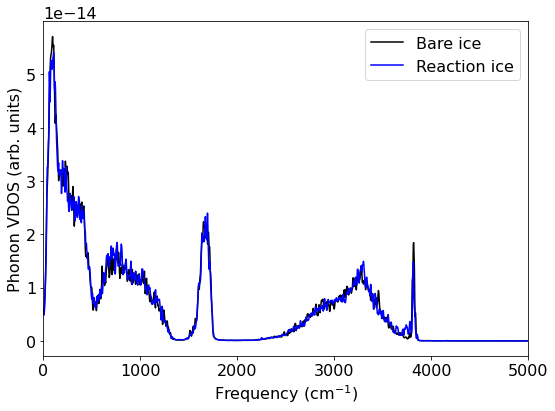

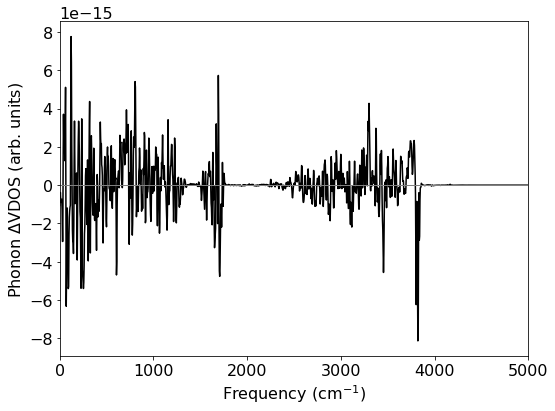

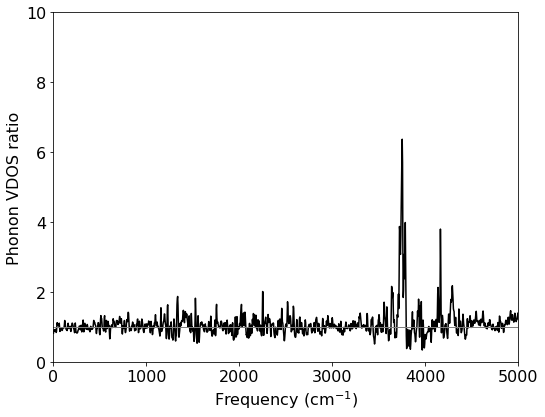

In [7]:
import pwtools as pwt
import pwtools.pydos as pydos
from   pwtools.constants import fs,rcm_to_Hz

def PLOT_PDOS(frq, pdos, name=None, leg=None,frq_lims=[0,5000],ylab="Phonon VDOS (arb. units)"):
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,6))
    if leg != None:
        ax.plot(frq/rcm_to_Hz,pdos,lw=1.5,c='k',label=leg)
    else:
        ax.plot(frq/rcm_to_Hz,pdos,lw=1.5,c='k')
    ax.set_xlabel(r"Frequency (cm$^{-1}$)")
    ax.set_ylabel(ylab)
    ax.set_xlim(frq_lims) # cm-1
    plt.tight_layout()
    if name != None:
        plt.savefig(name,dpi=200)
    return ax

#----------------
#-- BARE ICE DATA (after termalization, I run an NVE of the ice alone, to be able to substract the spectrum)
inFile_ice_pos = "/Users/enriquej/Desktop/CALC/CSUC/MD/mySYS/Bare_Ice_NVE/ice_nve_md-pos-1.xyz"
inFile_ice_vel = "/Users/enriquej/Desktop/CALC/CSUC/MD/mySYS/Bare_Ice_NVE/ice_nve_md-vel-1.xyz"

myICE = FAST_POS_VEL_READER(inFile_ice_pos,inFile_ice_vel)

n_ice = len(myICE)
print("Bare ice NVE length:",n_ice)
v_ice = np.array([at.get_velocities() for at in myICE])
m_ice = myICE[0].get_masses() # in amu

frq_ice, pdos_ice = pwt.pydos.pdos(v_ice[:n_ice], dt=1.0*fs, m=m_ice, method='direct', npad=1, area=1.0) # normalized to 1
ax_ice = PLOT_PDOS(frq=frq_ice, pdos=pdos_ice, leg="Bare ice")

#----------------
#-- ICE w/ REACTION
# Prepare data, by just taking the stuff in the ice
ice_data = [i.copy() for i in myMD]
for i in ice_data:
    del i[REAGENTS]

n_rx = len(ice_data)
v_rx = np.array([at.get_velocities() for at in ice_data])
m_rx = ice_data[0].get_masses() # in amu

# limited to the same nr of steps of the bare ice (for resolution)
frq_rx,pdos_rx = pwt.pydos.pdos(v_rx[:n_ice], dt=1.0*fs, m=m_rx, method='direct', npad=1, area=1.0)
line_, = ax_ice.plot(frq_rx/rcm_to_Hz,pdos_rx,lw=1.5,c="blue") # plot rx one on top
#ax_rx = plot_PDOS(frq=frq_rx, pdos=pdos_rx, name=OUT_DIR+"/PDOS.png")

handles,lables = ax_ice.get_legend_handles_labels(); handles.append(line_); lables.append("Reaction ice"); ax_ice.legend(handles,lables)

plt.tight_layout()
plt.savefig(OUT_DIR+"PDOS.png",dpi=200)
plt.show()

#----------------
#-- DIFFERENCE
ax_diff = PLOT_PDOS(frq=frq_ice, pdos=(pdos_rx-pdos_ice), ylab=r"Phonon $\Delta$VDOS (arb. units)",name=OUT_DIR+"/PDOS_difference.png")
xl,xh=ax_diff.get_xlim()
ax_diff.plot([xl,xh],[0,0],lw=1,c='grey')
plt.savefig(OUT_DIR+"PDOS_diff.png",dpi=200)
plt.show()
#----------------
#-- RATIO
ax_ratio = PLOT_PDOS(frq=frq_ice, pdos=(pdos_rx/pdos_ice), ylab=r"Phonon VDOS ratio",name=OUT_DIR+"/PDOS_ratio.png")
ax_ratio.set_ylim([0,10])
xl,xh=ax_ratio.get_xlim()
ax_ratio.plot([xl,xh],[1,1],lw=1,c='grey')
plt.show()

In [8]:
#view(ice_data)
#view(myMD[0][1732,1728])

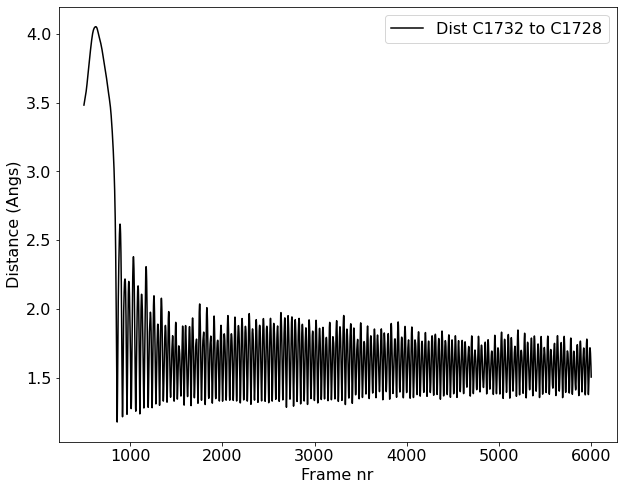

In [9]:
importlib.reload(sys.modules['CALC_fns'])
import CALC_fns
from scipy.signal import find_peaks

at1,at2 = 1732,1728
frame1,frame2 = 500,6000#len(myMD)

x_axis = [i for i in range(len(myMD))]
dist_data = CALC_fns.GET_DIST_EVOLUTION(at1,at2,myMD)

fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(10,8))
ax.plot(x_axis[frame1:frame2], dist_data[frame1:frame2],c='k',label="Dist {}{} to {}{}".format(myMD[0].get_chemical_symbols()[at1],at1,myMD[0].get_chemical_symbols()[at1],at2))

if 0:
    list_indx_min, rubish = find_peaks(1./np.array(dist_data[frame1:frame2]))
    list_indx_max, rubish = find_peaks(np.array(dist_data[frame1:frame2]))
    ax.scatter([i+frame1 for i in list_indx_min],dist_data[[i+frame1 for i in list_indx_min]],facecolor='k',marker='o',s=10**2,alpha=0.6)
    ax.scatter([i+frame1 for i in list_indx_max],dist_data[[i+frame1 for i in list_indx_max]],facecolor='k',marker='d',s=10**2,alpha=0.6)
    
ax.set_xlabel("Frame nr")
ax.set_ylabel("Distance (Angs)")
ax.legend()
plt.show()

## Vibrational quantum number analysis

**ATTENTION**
You need to modify the input here!

In [34]:
###############
# INPUT
###############

# Conversion factors
kJmol_to_J = (1000.0 / 6.022e23) # multiply this times an energy in kJmol to convert it in J
amu_to_kg  = 1.66053907e-27
angs_to_m  = 1.0e-10
cm1_to_Hz  = 29979245799.999996  

# Parameters
dframe = 500  # chunk size (in steps)
frame1 = 500  # where does the analysis start?
well_depth = 300.0 * kJmol_to_J # Well depth (prod-react) in J without ZPE!
red_mass   = ((16.0+3.0)/2.0) * amu_to_kg # reduced mass in kg (e.g. for radical coupling: m(rad1)m(rad2)/[m(rad1) + m(rad2)])
DFTfrequency = 1002.814331 * cm1_to_Hz # Calculated with a freq job on the gas phase molecule. Must correspond to the mode of interest
# f_c(h3)-c(h3) = 1002.814331 cm-1
dist_eq    = 1.56*angs_to_m # m
print("DFTfrequency = {:.3e}".format(DFTfrequency))

DFTfrequency = 3.006e+13


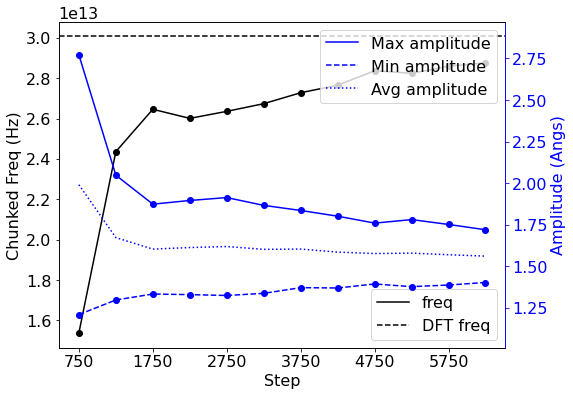

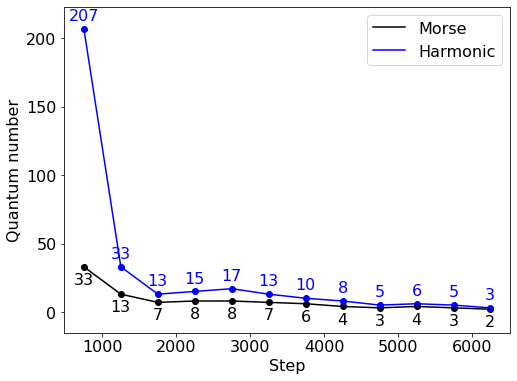

CPU times: user 521 ms, sys: 80.1 ms, total: 601 ms
Wall time: 246 ms


In [36]:
%%time

# BREAK MD into chunks
chunks        = CALC_fns.MAKE_CHUNKS(frame1, dframe, len(myMD))
chunks_center = [ch+(chunks[i+1]-chunks[i])/2 for i,ch in enumerate(chunks[:-1])]

# MEASURE freqs and max/min distances
list_frqs    = [ CALC_fns.MEASURE_FRQ(dist_data,chunks[i+1-1],chunks[i+1],dt=1.0,which='maxima') for i,chunk in enumerate(chunks[1:]) ]
avgd_maxdist = [ CALC_fns.MEASURE_MaxDist(dist_data,chunks[i+1-1],chunks[i+1],dt=1) for i,chunk in enumerate(chunks[1:]) ]
avgd_mindist = [ CALC_fns.MEASURE_MinDist(dist_data,chunks[i+1-1],chunks[i+1],dt=1) for i,chunk in enumerate(chunks[1:]) ]
list_r = avgd_maxdist

# CALCULATE quantum numbers
list_V_harm = [CALC_fns.V_HARMONIC(r*1e-10,dist_eq,DFTfrequency,red_mass) for r in list_r]
list_n_harm = [CALC_fns.n_HARMONIC(V,DFTfrequency) for V in list_V_harm]

list_V_morse = [CALC_fns.V_MORSE(r*1.0e-10,dist_eq,well_depth,DFTfrequency,red_mass) for r in list_r]
list_n_morse = [CALC_fns.n_MORSE(V,well_depth,DFTfrequency) for V in list_V_morse]

### PLOT FREQ and DISTS
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,6))

ax.plot(   chunks_center,list_frqs,c='k',label='freq')
ax.scatter(chunks_center,list_frqs,c='k')
ax.axhline(DFTfrequency,c='k',ls='--',label='DFT freq')

ax.set_ylabel("Chunked Freq (Hz)")
ax.set_xlabel("Step")
ax.set_xticks(chunks_center[::2])
ax.set_xticklabels([str(int(i)) for i in chunks_center[::2]])

ax2=ax.twinx()
ax2.plot(   chunks_center,avgd_maxdist,c='b',label="Max amplitude")
ax2.scatter(chunks_center,avgd_maxdist,c='b')

ax2.plot(   chunks_center,avgd_mindist,c='b',ls="--",label="Min amplitude")
ax2.scatter(chunks_center,avgd_mindist,c='b')

ax2.plot(   chunks_center,[(i+j)/2.0 for i,j in zip(avgd_mindist,avgd_maxdist)],c='b',ls=":",label="Avg amplitude")

ax2.set_ylabel("Amplitude (Angs)")
ax2.yaxis.label.set_color('blue')
ax2.tick_params(axis='y', colors='blue')
ax.spines['right'].set_color('blue')
ax2.spines['right'].set_color('blue')
ax2.set_xlabel("Step")
#ax2.set_xticks(chunks_center[::2])
ax2.set_xticklabels([str(int(i)) for i in chunks_center[::2]])
ax2.set_ylim([min(avgd_mindist)-0.2,max(avgd_maxdist)+0.2])

ax.legend()
ax2.legend()

plt.show()

#print('Last average distance: {:.4f} Angs\n'.format([(i+j)/2.0 for i,j in zip(avgd_mindist,avgd_maxdist)][-1]))

### PLOT quantum numbers (harm and morse)
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(8,6))
ax.plot(chunks_center,list_n_morse,label='Morse',c='k')
ax.scatter(chunks_center,list_n_morse,c='k')
# Add text lables to morse
for i,j in zip(chunks_center,list_n_morse):
    ax.text(x=i,y=j-4,s=str(j),ha='center', va='top',c='k')

ax.plot(chunks_center,list_n_harm,label='Harmonic',c='b')
ax.scatter(chunks_center,list_n_harm,c='b')
# Add text lables to Harmonic
for i,j in zip(chunks_center,list_n_harm):
    ax.text(x=i,y=j+4,s=str(j),ha='center', va='bottom',c='b')
ax.set_ylim([ax.get_ylim()[0]-7,ax.get_ylim()[1]+6])
ax.set_ylabel('Quantum number')
ax.set_xlabel('Step')
plt.legend()
plt.show()